<h3> Pretext Task </h3>

In [39]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder

class MeasuresDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Initialize label encoder for Description column
        self.label_encoder = LabelEncoder()
        self.data['Encoded_Description'] = self.label_encoder.fit_transform(self.data['Description'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        page = str(int(self.data.iloc[idx]['Page']))
        encoded_description = self.data.iloc[idx]['Encoded_Description']

        img_path = os.path.join(self.image_dir, f"{page}.jpg")
        
        # Open image and apply transformations
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
            
        return image, encoded_description


# Assuming preprocess function and device are defined elsewhere
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as per model requirements
    transforms.ToTensor()
])

dataset = MeasuresDataset(csv_file='measures_context.csv', image_dir='./combined', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define a pretext task network
class PretextTaskModel(nn.Module):
    def __init__(self, num_classes):
        super(PretextTaskModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.fc = nn.Linear(1000, num_classes)  # Adjust output size for your context labels

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

# Define pretext task loss function
pretext_criterion = nn.CrossEntropyLoss()

# Initialize pretext task model
pretext_model = PretextTaskModel(num_classes=20)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretext_model.to(device)

# Define dataloader for unlabeled data (images without context labels)
# You need to implement a DataLoader for your unlabeled data

# Define optimizer
pretext_optimizer = optim.Adam(pretext_model.parameters(), lr=0.001)




c:\Users\yashs\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yashs\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define a pretext task network
class PretextTaskModel(nn.Module):
    def __init__(self, num_classes):
        super(PretextTaskModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.fc = nn.Linear(1000, num_classes)  # Adjust output size to match the number of classes

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)  # Flatten the output of ResNet before passing it to the linear layer
        x = self.fc(x)
        return x


# Define pretext task loss function
pretext_criterion = nn.CrossEntropyLoss()

# Initialize pretext task model
pretext_model = PretextTaskModel(num_classes=20)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretext_model.to(device)

PretextTaskModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

<h3> Training Pretext on Unlabeled Data </h3>

In [42]:
losses=[]
for epoch in range(5):
    for images, context_labels in dataloader:
        images = images.to(device)
        context_labels = context_labels.to(device)
        
        # Convert context_labels to torch.long
        context_labels = context_labels.long()
        
        # Zero the gradients
        pretext_optimizer.zero_grad()
        
        # Forward pass
        outputs = pretext_model(images)
        
        # Calculate pretext task loss
        loss = pretext_criterion(outputs, context_labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        pretext_optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss.item())
    

Epoch 1, Loss: 3.957778215408325
Epoch 2, Loss: 3.4335100650787354
Epoch 3, Loss: 3.660186290740967
Epoch 4, Loss: 3.6788835525512695
Epoch 5, Loss: 3.7159814834594727


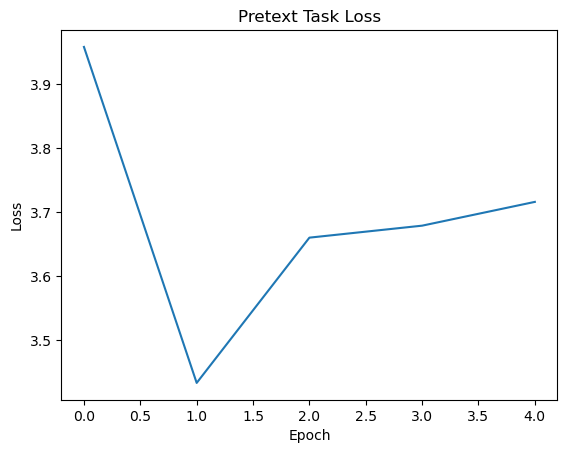

In [43]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pretext Task Loss')
plt.show()